In [1]:
#

import mne
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.signal import butter, lfilter,resample,coherence
from scipy import io
from scipy import stats
import librosa
from scipy.signal import hilbert
from IPython.display import clear_output

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
import matplotlib as mpl

data_path = os.path.dirname(os.getcwd())

subject_name = ['stella','juliet','shai','ayoub','lucas','simone','henry', 'julien','marion','elvira']
subject_group = [('stella','juliet'),('shai','ayoub'),('lucas','simone'),('henry', 'julien'),('marion','elvira')]
#subject_group = [1,1,2,2,3,3,4,4,5,5]
subject_gender = ['f','f','m','m','m','m','m','m','f','f']
subject_speak = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
session_name = ['pre','duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6','post']
session_words = [60,50,50,50,50,50,50,60]
eeg_label =     ['F3','C3','P3','Cz','F4','C4','P4','P7']
ema_label = ['jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

ema_fs = 100

idx = [np.arange(1,60),np.arange(61,160),np.arange(161,260),np.arange(261,360),np.arange(361,460)
       ,np.arange(461,560),np.arange(561,660),np.arange(661,720)]

raw_fname = data_path + '/fieldtrip/data/enobio8_ferrara_french2.mat'
mat = io.loadmat(raw_fname)
pos = mat['lay']['pos'][0][0]



In [2]:
# https://paper.dropbox.com/doc/Convergence-vs-Neural-Entrainment-oSnHwqsKTyVLMDlSYsawr

In [16]:
save_path = data_path + '/python/data/data.pkl'
data=pd.read_pickle(save_path)


In [17]:
resample_freq=100

In [18]:
# data function

#get listening eeg and speking envelop
def get_epoches_eegPlusothers(A,session):
    s1,s2=np.unique(A['subject'])
    if(session=='all'):
        a = A[A['type']=='L']
    else:
        a = A[(A['type']=='L')&(A['session']==session)]
        
    B=[]
    c=[]
    for i in range(0,len(a)):
        B.append(np.vstack((a.iloc[i]['data'],a.iloc[i]['envelop'])))
        c.append(B[i].shape[1])
    c=max(np.stack(c))

    aa=[]
    sub=[]
    for i in range(0,len(B)):
        sub.append(a.iloc[i]['subject'])
        if(B[i].shape[1]<c):
            tmp = np.pad(B[i], ((0,0),(0,c-B[i].shape[1])), 'constant')
            aa.append(tmp)
        else:
            aa.append(B[i])    
    sub=np.stack(sub)     
    
    aa = np.stack(aa)
    aa_s1= aa[np.where(sub==s1)[0],:,:]
    aa_s2= aa[np.where(sub==s2)[0],:,:]
    
    return aa,aa_s1,aa_s2,s1,s2


In [64]:
# power
tmp =     ['F3','C3','P3','Cz','F4','C4','P4','P7','envelop']
AA=[]
BB=[]
for s in range(0,5):
    save_path = data_path + '/python/data/'+'_'.join(subject_group[4])+'_EEG.pkl'
    A=pd.read_pickle(save_path) 
    
    epoches,s1,s2,s1_name,s2_name=get_epoches_eegPlusothers(A,'all')

    psds ,freq = mne.time_frequency.psd_array_multitaper(s1,sfreq=100)
    AA.append(np.mean(psds,axis=0))
    BB.append(freq)
    psds ,freq = mne.time_frequency.psd_array_multitaper(s1,sfreq=100)
    AA.append(np.mean(psds,axis=0))
    BB.append(freq)

    
AA=np.stack(AA)
BB=np.stack(BB)

A=[]
for s in range(10):
    for f in range(BB.shape[1]):
        for ch in range(9):
            a=pd.DataFrame({'freq':[BB[s,f]],'psd':AA[s,ch,f],'subject':subject_name[s],'channel':tmp[ch]})
            A.append(a)

A=pd.concat((A),axis=0)
clear_output()
A.head()

,freq,psd,subject,channel
0,0.0,1.769349e+09,stella,F3
0,0.0,8.219117e+08,stella,C3
0,0.0,5.527394e+08,stella,P3
0,0.0,1.202572e+09,stella,Cz
0,0.0,1.107517e+09,stella,F4


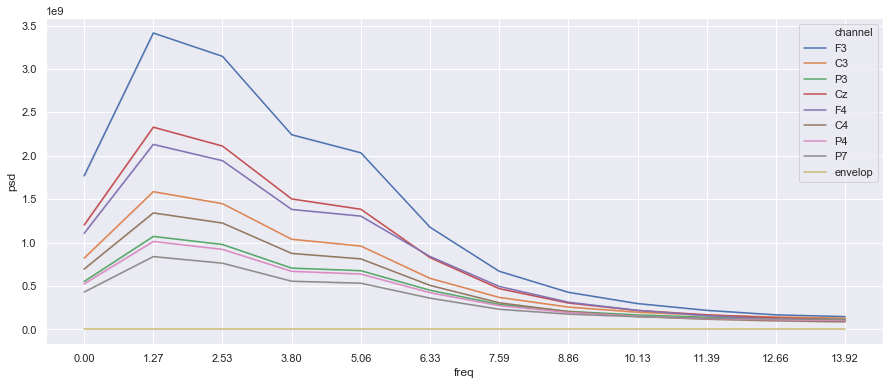

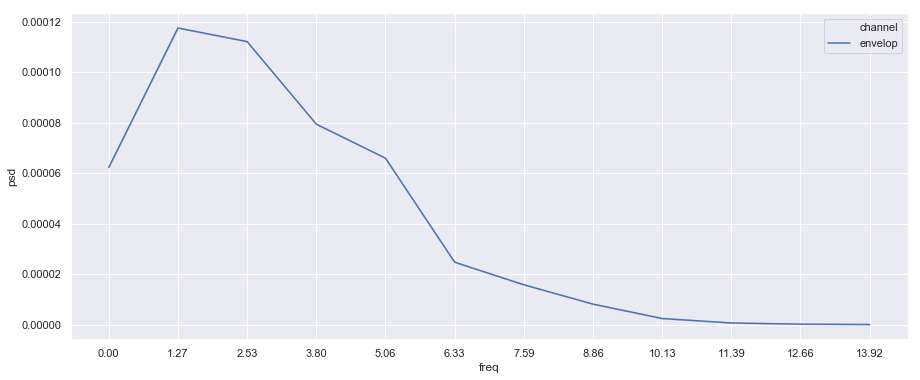

In [67]:
#
A = A[(A['freq']<=15)]
freq = np.unique(A['freq'])

f, AX = plt.subplots(figsize=(15,6))
_=sns.lineplot(x='freq',y='psd',hue='channel',data=A)
_=plt.xticks(freq)
#_=plt.xlim([-1,15])

f, AX = plt.subplots(figsize=(15,6))
a = A[A['channel']=='envelop']
_=sns.lineplot(x='freq',y='psd',hue='channel',data=a)
_=plt.xticks(freq)
#_=plt.xlim([-1,15])

In [162]:
fmin = 0.5
fmax = 30.5
method = 'coh'
mode = 'cwt_morlet' # 'fourier'
cwt_freqs = np.arange(fmin,fmax,0.5)
cwt_n_cycles= 3

In [163]:
# compute coherence

features=[1]
indices = (np.repeat([np.arange(8,len(features)+8)],8),np.tile(np.arange(0,8),len(features))) 


def get_coherence(epoches, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles):
    con,freqs,_,_,_= mne.connectivity.spectral_connectivity(epoches, method=method,
                                                            mode=mode,
                                                        sfreq=resample_freq, fmin = fmin,fmax=fmax,
                                                        indices=indices, cwt_freqs=cwt_freqs,
                                                            faverage=False,n_jobs =6,
                                                           cwt_n_cycles = cwt_n_cycles)
    freqs = np.round(freqs,decimals=1)
    
    if(len(con.shape)==3):
        con=np.mean(con,axis=2)
        
    return con,freqs

tmp=[]
for s in range(0,5):
    save_path = data_path + '/python/data/'+'_'.join(subject_group[s])+'_EEG.pkl'
    A=pd.read_pickle(save_path)    
    
    epoches,s1,s2,s1_name,s2_name=get_epoches_eegPlusothers(A,'all')
    
    #both
    con,freqs = get_coherence(epoches, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles)
    
    for fr in range(0,len(freqs)):
        a = freqs[fr]
            
        df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':'both',
                         'session_name':'all','session':0,
                         'freq':a,'Data':[con[:,fr]]})
        tmp.append(df)

    #s1    
    con,freqs = get_coherence(s1, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles)

    for fr in range(0,len(freqs)):
        a = freqs[fr]
            
        df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s1_name,
                         'session_name':'all','session':0,
                         'freq':a,'Data':[con[:,fr]]})
        tmp.append(df)
        
    #s2    
    con,freqs = get_coherence(s2, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles)

    for fr in range(0,len(freqs)):
        a = freqs[fr]
            
        df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s2_name,
                         'session_name':'all','session':0,
                         'freq':a,'Data':[con[:,fr]]})
        tmp.append(df)
        
        
    for i in range(1,len(session_name)-1):
        epoches,s1,s2,s1_name,s2_name=get_epoches_eegPlusothers(A,session_name[i])
        
        #both
        con,freqs = get_coherence(epoches, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles)

        for fr in range(0,len(freqs)):
                a = freqs[fr]
                df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':'both',
                                 'session_name':session_name[i],'session':i,
                                 'freq':a,'Data':[con[:,fr]]})
                tmp.append(df)
                
        #s1
        con,freqs = get_coherence(s1, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles)

        for fr in range(0,len(freqs)):
                a = freqs[fr]
                df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s1_name,
                                 'session_name':session_name[i],'session':i,
                                 'freq':a,'Data':[con[:,fr]]})
                tmp.append(df)        
                
         #s2
        con,freqs = get_coherence(s2, method,mode,resample_freq,fmin,fmax,indices,cwt_freqs,cwt_n_cycles)

        for fr in range(0,len(freqs)):
                a = freqs[fr]
                df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s2_name,
                                 'session_name':session_name[i],'session':i,
                                 'freq':a,'Data':[con[:,fr]]})
                tmp.append(df)        
                
        print(str(s)+'-'+str(i)+'-'+str(fr))
        clear_output()    
    
df=pd.concat((tmp),axis=0)
save_path = data_path + '/python/data/entrement_'+method+'_'+mode+'.pkl'
df.to_pickle(save_path)

In [164]:
# load coherence with speech envelope data during listening

save_path = data_path + '/python/data/entrement_coh.pkl'
save_path = data_path + '/python/data/entrement_'+method+'_'+mode+'.pkl'

df=pd.read_pickle(save_path)

a  = df['Data'].apply(lambda x: np.mean(x))
df['Coherence'] = pd.Series(a, index=df.index)
A = df.reset_index()
a = pd.DataFrame(np.column_stack(list(zip(*A.Data))), columns=eeg_label)
df = pd.concat([A,a], axis=1)



B=df.drop(['Data','index'], axis=1)
B=B.reset_index()

A = B.melt(['index','name','group','subject','session_name','session',
            'freq','Coherence'], var_name='channel', value_name='data')
A = A.drop(['index'], axis=1)

A.head()

,name,group,subject,session_name,session,freq,Coherence,channel,data
0,stella_juliet,0,both,all,0,0.5,0.054851,F3,0.058594
1,stella_juliet,0,both,all,0,1.0,0.049137,F3,0.044296
2,stella_juliet,0,both,all,0,1.5,0.040943,F3,0.038049
3,stella_juliet,0,both,all,0,2.0,0.036616,F3,0.037630
4,stella_juliet,0,both,all,0,2.5,0.033616,F3,0.036123


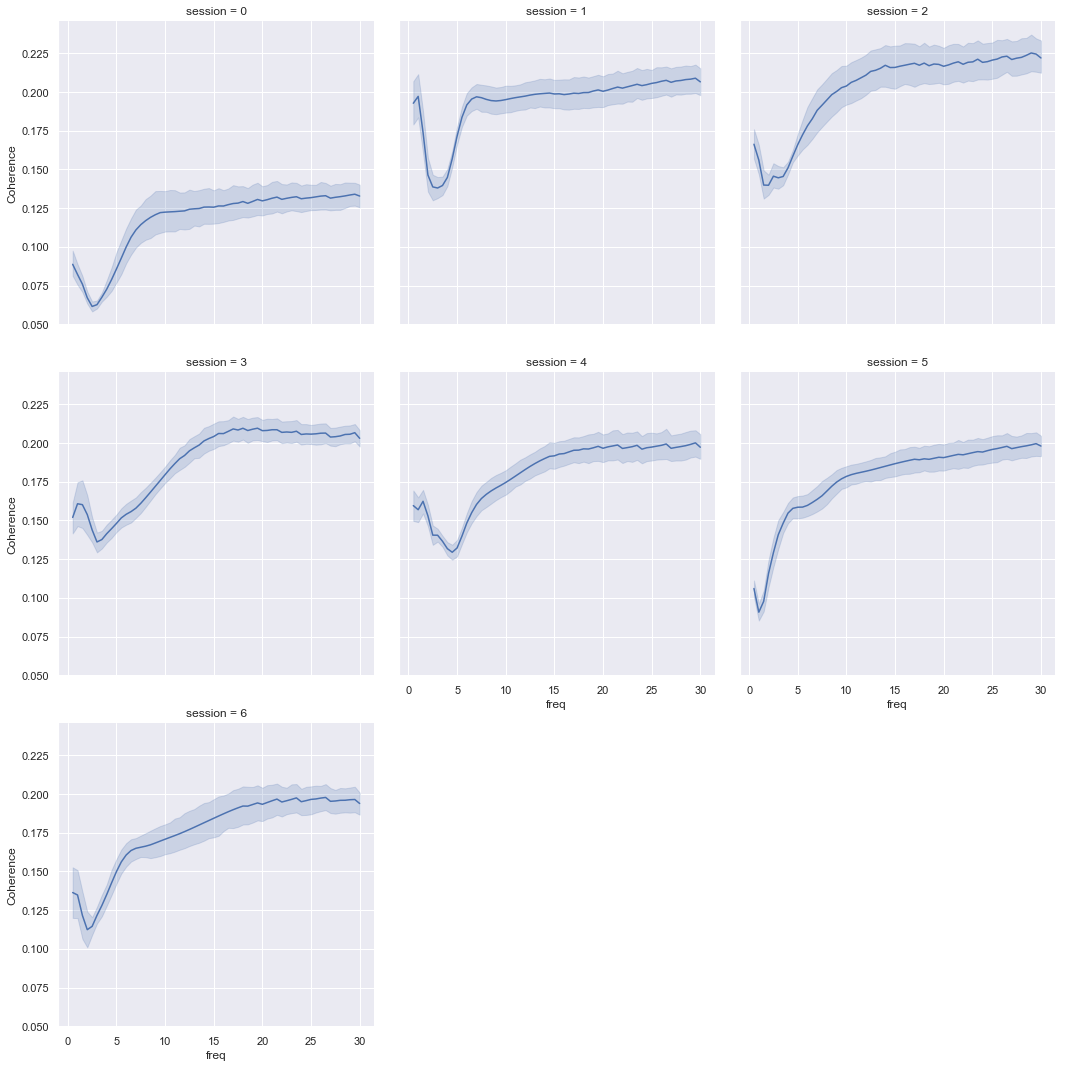

In [165]:
freq = cwt_freqs

a = A[(A['subject'] != 'both')&(A['freq'].isin(freq))]
_=sns.relplot(x="freq", y="Coherence", col="session",col_wrap=3,
            kind="line", legend="full", data=a)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


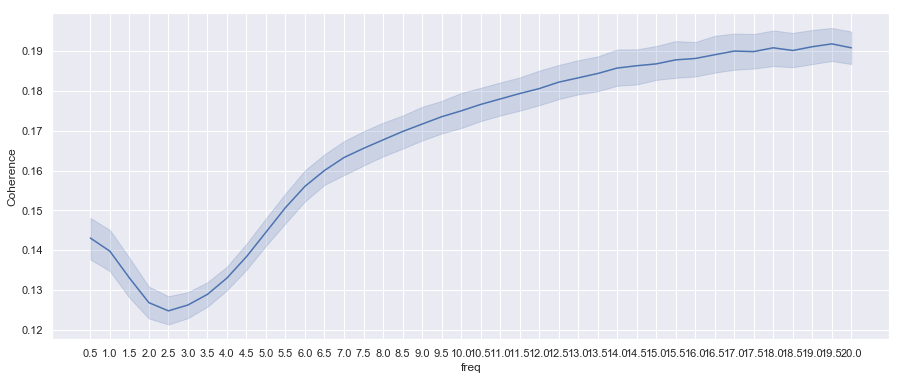

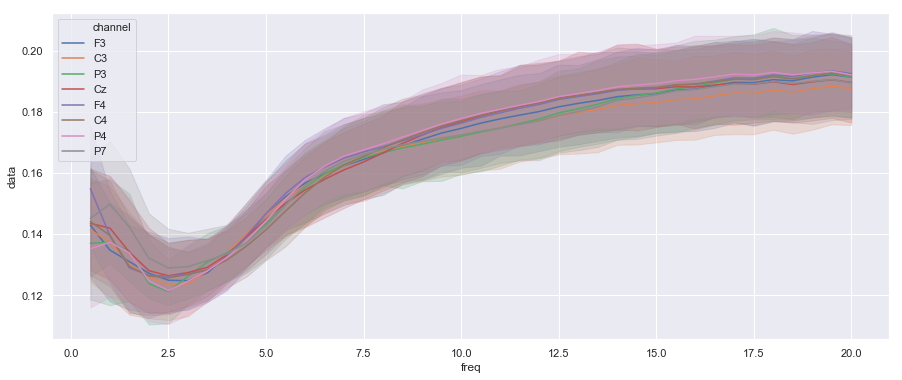

In [161]:
#Coherence
sns.set(font_scale=1)

freq = cwt_freqs

a = A[(A['subject'] != 'both')&(A['freq'].isin(freq))]
print(np.unique(a['freq']))
f, AX = plt.subplots(figsize=(15,6))

ax = sns.lineplot(x="freq", y="Coherence",data=a,markers=True)
_=plt.xticks(np.unique(a['freq']))


f, AX = plt.subplots(figsize=(15,6))

ax = sns.lineplot(x="freq", y="data",hue='channel',data=a,markers=True)
#_=plt.xticks(np.unique(a['freq']))

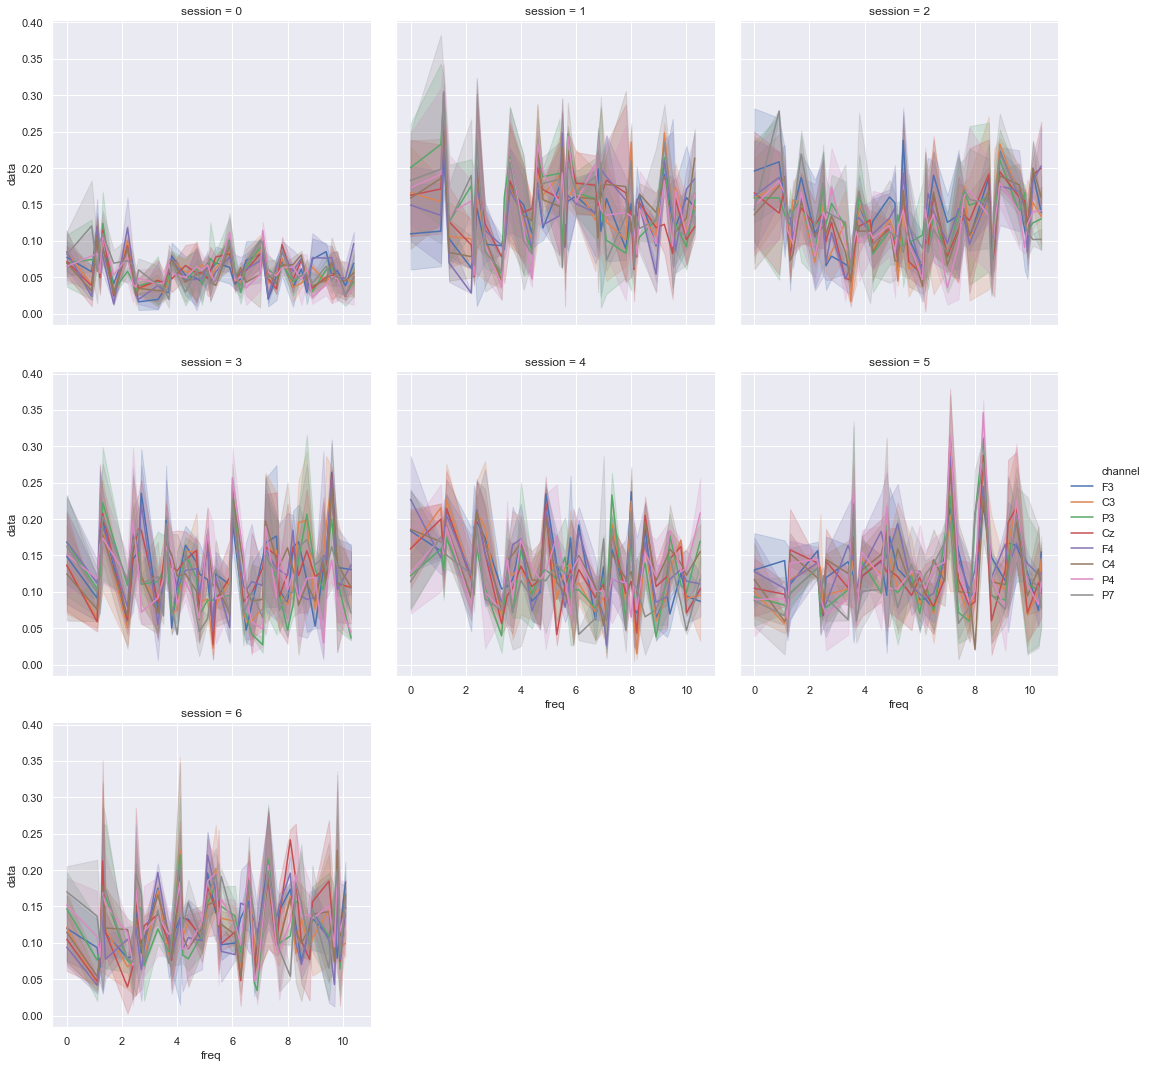

In [86]:
a = A[(A['subject'] != 'both')&(A['freq']<=fmax)]
_=sns.relplot(x="freq", y="data", hue='channel',col="session",col_wrap=3,
            kind="line", legend="full", data=a)

In [148]:
freq=[1,4]


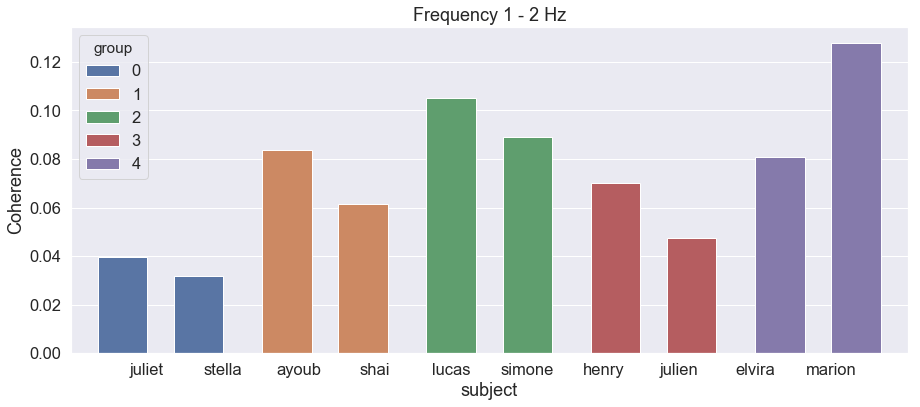

In [149]:
#

a = A[(A['session'] == 0)&(A['subject'] != 'both')
      &(A['freq'].between(freq[0], freq[1], inclusive=False))]

f, AX = plt.subplots(figsize=(15,6))
ax = sns.barplot(x="subject", y="Coherence", hue='group',data=a)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .65)
_=plt.title('Frequency '+str(freq[0])+' - '+str(freq[1])+' Hz')
_=plt.xlim([-1,10])

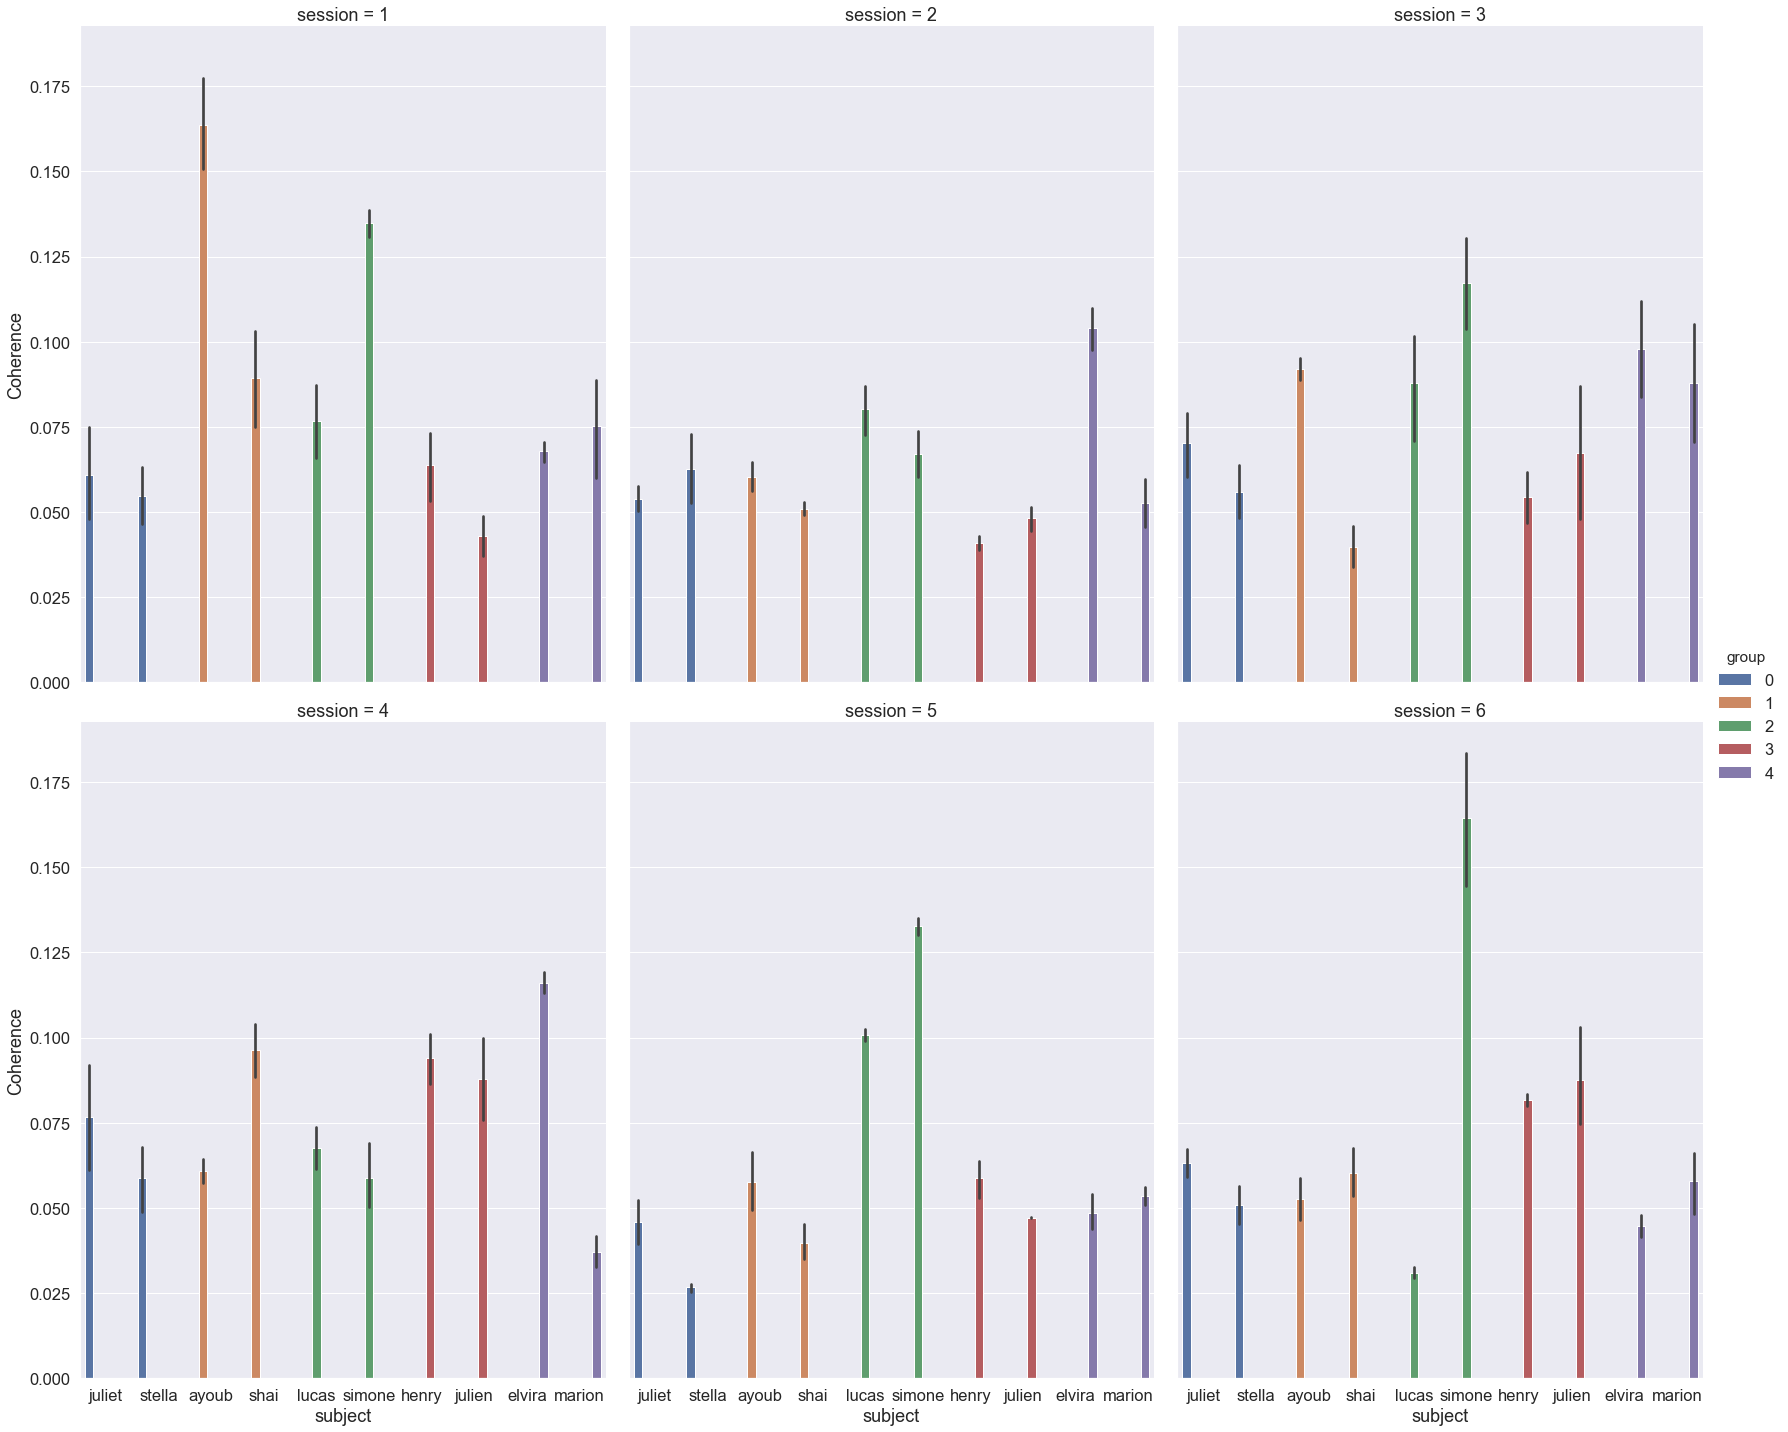

In [74]:
#

a = A[(A['session'] == 0)&(A['subject'] != 'both')
      &(A['freq'].between(freq[0], freq[1], inclusive=False))]

g = sns.catplot(x="subject", y='Coherence', hue='group',
                col="session", col_wrap=3,data=a,kind="bar",
               height=10, aspect=.8)



# plv

In [9]:
# plv functions

def get_connectivity(epoches,resample_freq,fmin, fmax):
    filt = mne.filter.filter_data(epoches,resample_freq,fmin, fmax, 
                                             method = 'iir',n_jobs=1,
                                       iir_params = dict(order=4, ftype='butter', output='sos') 
                              ,verbose ='ERROR')
    filt,filt_trial=get_plv(filt)

    return filt.flatten(),filt_trial

def get_plv(filt):
    X = hilbert(filt)
    trial = filt.shape[0]
    
    coh_ch1 = np.zeros((trial,8,1))
    for t in range(0,trial):
        for feat in range(1):
            ss = X[t,feat+8,:]
            for ch in range(8):
                #eeg = np.angle(scipy.signal.hilbert(filt[t,ch,:]))
                #ss = np.angle(scipy.signal.hilbert(filt[t,59,:]))
                #l = np.angle(scipy.signal.hilbert(filt[t,60,:]))
                eeg = X[t,ch,:]
                coh_ch1[t,ch,feat] = phase_locking_value(eeg,ss)
                #coh_ch1[t,ch,feat] = phase_coherence(eeg,ss)
    return np.mean(coh_ch1,axis=0),coh_ch1

def phase_locking_value(s1, s2):
    theta1 = np.angle(s1)
    theta2 = np.angle(s2)
    complex_phase_diff = np.exp(np.complex(0,1)*(theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

def phase_coherence(s1,s2):
    theta1 = np.angle(s1)
    theta2 = np.angle(s2)
    r1 = np.absolute(s1)
    r2 = np.absolute(s2)
    complex_phase_diff = np.exp(np.complex(0,1)*(theta1 - theta2))
    complex_amp_mul = r1*r2
    
    numerator = np.abs(np.sum(complex_amp_mul*complex_phase_diff))/len(theta1)   
    denominator = np.sqrt((np.sum(np.square(r1))*np.sum(np.square(r2)))/len(theta1)*len(theta1))
    pcoh = numerator/denominator
    
    return pcoh

In [210]:
# compute PLV

freq = np.vstack((np.arange(0.5,40,1),np.arange(2.5,42,1))).T
freq = np.vstack((np.arange(0.5,10,1),np.arange(2.5,12,1))).T
freq = np.array([[1,4],[4,8]])


tmp=[]
temp2=[]
for s in range(0,5):
    save_path = data_path + '/python/data/'+'_'.join(subject_group[s])+'_EEG.pkl'
    A=pd.read_pickle(save_path)    
    
    epoches,s1,s2,s1_name,s2_name=get_epoches_eegPlusothers(A,'all')
    for f in range(0,len(freq)):
        AA,AA_trial = get_connectivity(epoches,resample_freq,freq[f][0], freq[f][1])

        a = A['subject'].get_values()
        b = A['session'].get_values()

        s1_idx=np.where(a==s1_name)[0]
        s2_idx=np.where(a==s2_name)[0]
        
        
        #both
        df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':'both',
                         'session_name':'all','session':0,
                         'freq_name':'_'.join((str(freq[f][0]),str(freq[f][1]))),
                         'freq':(freq[f][1]+freq[f][0])/2,
                         'Data':[AA]})
        tmp.append(df)
        
        #s1
        #AA,AA_trial = get_connectivity(s1,resample_freq,freq[f][0], freq[f][1])
        df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s1_name,
                         'session_name':'all','session':0,
                         'freq_name':'_'.join((str(freq[f][0]),str(freq[f][1]))),
                         'freq':(freq[f][1]+freq[f][0])/2,
                         'Data':[AA_trial[s1_idx,:,:].mean(axis=0)]})
        tmp.append(df)
        
        #s2
        #AA,AA_trial = get_connectivity(s2,resample_freq,freq[f][0], freq[f][1])
        df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s2_name,
                         'session_name':'all','session':0,
                         'freq_name':'_'.join((str(freq[f][0]),str(freq[f][1]))),
                         'freq':(freq[f][1]+freq[f][0])/2,
                         'Data':[AA_trial[s2_idx,:,:].mean(axis=0)]})
        tmp.append(df)
        
        
        
        for i in range(1,len(session_name)-1):
            #both
            aa = np.where(b==session_name[i])[0]
            #AA,AA_trial = get_connectivity(epoches,resample_freq,freq[f][0], freq[f][1])
            df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':'both',
                             'session_name':session_name[i],'session':i,
                             'freq_name':'_'.join((str(freq[f][0]),str(freq[f][1]))),
                             'freq':(freq[f][1]+freq[f][0])/2,
                             'Data':[AA_trial[aa,:,:].mean(axis=0)]})
            tmp.append(df)

            #s1
            aa = np.where((a==s1_name)&(b==session_name[i]))[0]

            #AA,AA_trial = get_connectivity(s1,resample_freq,freq[f][0], freq[f][1])
            df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s1_name,
                             'session_name':session_name[i],'session':i,
                             'freq_name':'_'.join((str(freq[f][0]),str(freq[f][1]))),
                             'freq':(freq[f][1]+freq[f][0])/2,
                             'Data':[AA_trial[aa,:,:].mean(axis=0)]})
            tmp.append(df)

            #s2
            aa = np.where((a==s2_name)&(b==session_name[i]))[0]

            #AA,AA_trial = get_connectivity(s2,resample_freq,freq[f][0], freq[f][1])
            df=pd.DataFrame({'name':'_'.join(subject_group[s]),'group':s,'subject':s2_name,
                             'session_name':session_name[i],'session':i,
                             'freq_name':'_'.join((str(freq[f][0]),str(freq[f][1]))),
                             'freq':(freq[f][1]+freq[f][0])/2,
                             'Data':[AA_trial[aa,:,:].mean(axis=0)]})
            tmp.append(df)

        AA_trial = np.squeeze(AA_trial)
        a = pd.DataFrame(AA_trial)
        a.columns = eeg_label
        a['avg_channel'] = pd.Series(np.mean(AA_trial,axis=1), index=a.index)
        a['wordNo'] = pd.Series(A['wordNo'].get_values(), index=a.index)
        a['subject'] = pd.Series(A['subject'].get_values(), index=a.index)
        a['freq'] = pd.Series(np.repeat((freq[f][1]+freq[f][0])/2,a.shape[0]), index=a.index)

        aa = A['session'].apply(lambda x: session_name.index(x))
        a['session'] = pd.Series(aa.get_values(), index=a.index)
        temp2.append(a)
        print(str(s)+'-'+str(f),end=' ')
            
    clear_output()    


df=pd.concat((tmp),axis=0)
save_path = data_path + '/python/data/entrement_plv_'+str(freq[0])+\
                        '-'+str(freq[-1])+'.pkl'
df.to_pickle(save_path)

df=pd.concat((temp2),axis=0)
save_path = data_path + '/python/data/entrement_plv_trialwise_'+str(freq[0])+\
                        '-'+str(freq[-1])+'.pkl'
df.to_pickle(save_path)



In [138]:
#

group = ['stella_juliet', 'lucas_simone', 'shai_ayoub', 'marion_elvira', 'henry_julien']   
session = ['all','duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6']
freq=['1_4','4_8','8_12']
f=0

save_path = data_path + '/python/data/entrement_plv.pkl'
df=pd.read_pickle(save_path)    

A = df.reset_index()
a = pd.DataFrame(np.column_stack(list(zip(*A.Data))), columns=eeg_label)
df = pd.concat([A,a], axis=1)

   
B=df.drop(['Data','index'], axis=1)
B=B.reset_index()
A = B.melt(['index','group_name','group','session_name','session',
           'freq_name','freq'], var_name='channel', value_name='data')
A = A.drop(['index'], axis=1)

A.head()

,group_name,group,session_name,session,freq_name,freq,channel,data
0,stella_juliet,0,all,0,1_4,0,F3,0.523090
1,stella_juliet,0,all,0,4_8,1,F3,0.492705
2,stella_juliet,0,all,0,8_12,2,F3,0.427932
3,stella_juliet,0,duet1,1,1_4,0,F3,0.525565
4,stella_juliet,0,duet1,1,4_8,1,F3,0.515217


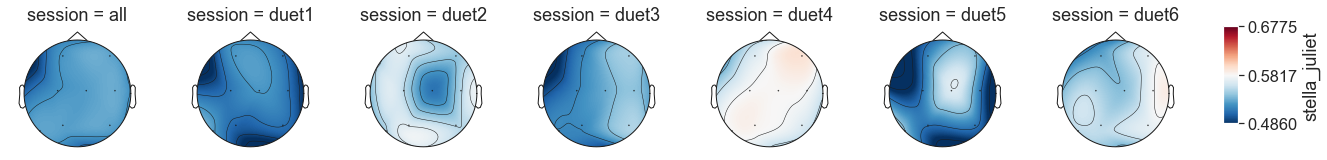

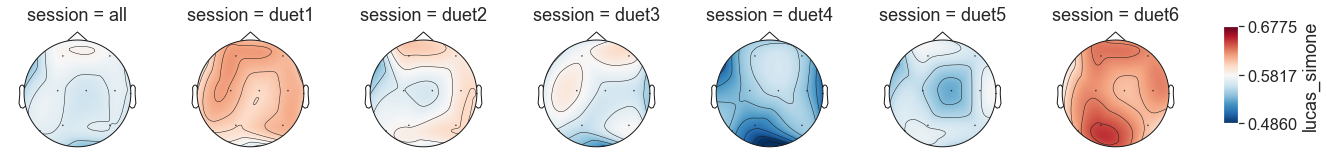

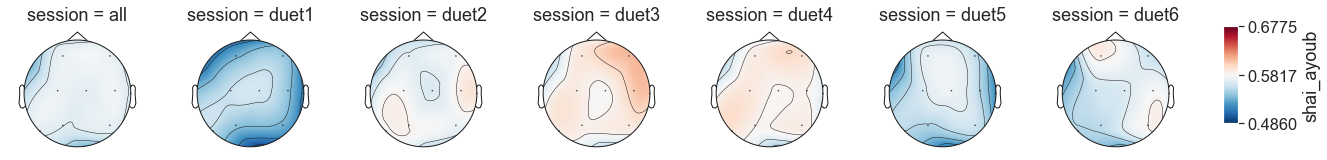

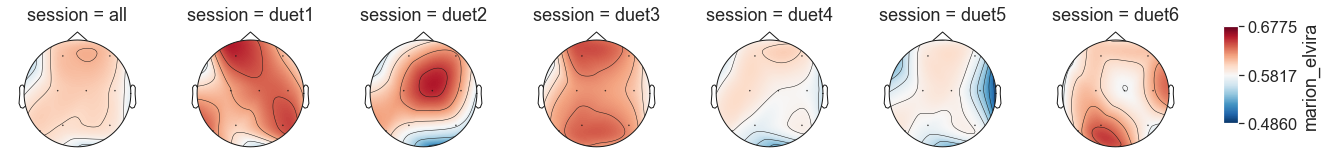

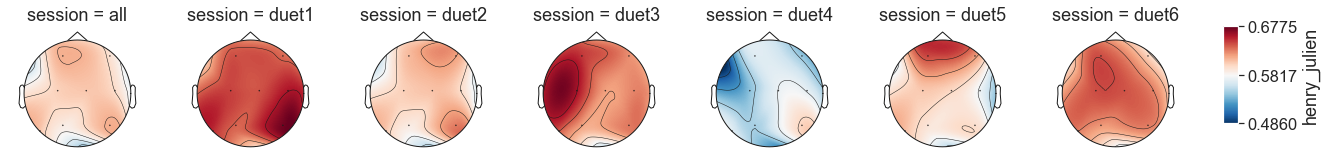

In [13]:
# entrainemnt (PLV) topo plot

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mne.viz.plot_topomap(x, pos, show=False,vmin=vmin,vmax=vmax,cmap='RdBu_r')

def plot_topo_image(df,vmin,vmax,typeF,cmap,g):
    
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,3),cax=cbar_ax,label=g)
    



A=[]
for g in group: 
    a = df[(df['group'] == g)&(df['freq'] == freq[f])]
    vmin = np.stack(a['Data'].get_values()).min()
    vmax = np.stack(a['Data'].get_values()).max()
    A.append((vmin,vmax))
A=np.stack(A)

for g in group: 
    a = df[(df['group'] == g)&(df['freq'] == freq[f])]
    vmin = A.min()
    vmax = A.max()   
        
    plot_topo_image(a,vmin,vmax,'session','RdBu_r',g)

In [140]:
a = A[(A['session'] == 0)]
a.head()

,group_name,group,session_name,session,freq_name,freq,channel,data
0,stella_juliet,0,all,0,1_4,0,F3,0.523090
1,stella_juliet,0,all,0,4_8,1,F3,0.492705
2,stella_juliet,0,all,0,8_12,2,F3,0.427932
21,shai_ayoub,1,all,0,1_4,0,F3,0.572115
22,shai_ayoub,1,all,0,4_8,1,F3,0.498543


Text(0.5, 1.0, '8_12')

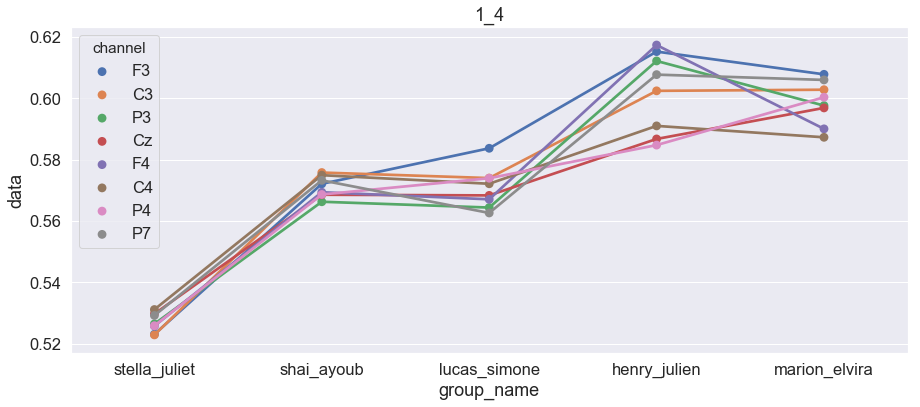

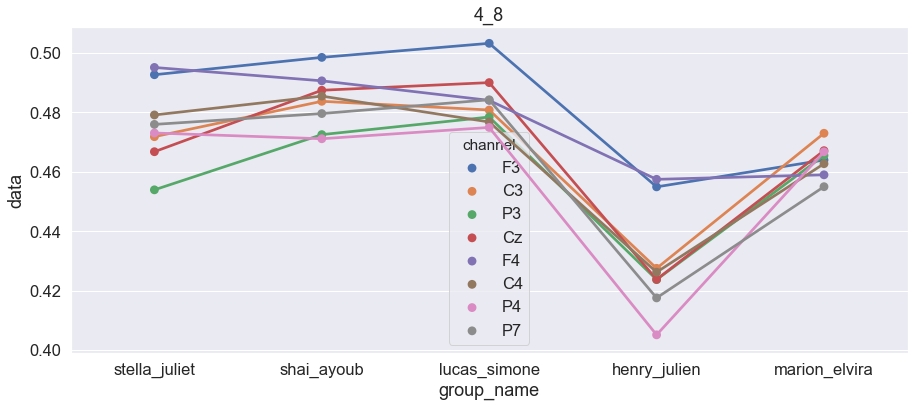

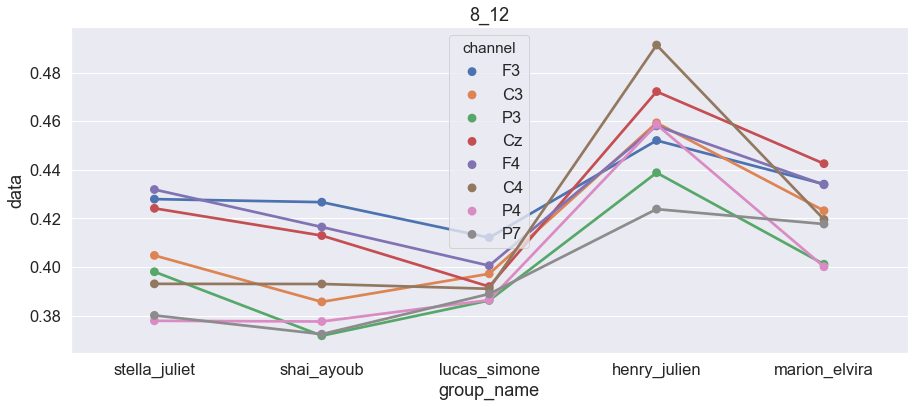

In [172]:
# all groups
a = A[(A['freq'] == 0)&(A['session'] == 0)]
f, AX = plt.subplots(figsize=(15,6))
ax = sns.pointplot(x="group_name", y="data", hue="channel", data=a)
plt.title(freq[0])

a = A[(A['freq'] == 1)&(A['session'] == 0)]
f, AX = plt.subplots(figsize=(15,6))
ax = sns.pointplot(x="group_name", y="data", hue="channel", data=a)
plt.title(freq[1])

a = A[(A['freq'] == 2)&(A['session'] == 0)]
f, AX = plt.subplots(figsize=(15,6))
ax = sns.pointplot(x="group_name", y="data", hue="channel", data=a)
plt.title(freq[2])

In [121]:
g=0
i=0
a = A[(A['freq'] == 0)&(A['session'] != 0)]
a.head()

,group_name,group,session_name,session,freq_name,freq,channel,data
3,stella_juliet,0,duet1,1,1_4,0,F3,0.525565
6,stella_juliet,0,duet2,2,1_4,0,F3,0.569966
9,stella_juliet,0,duet3,3,1_4,0,F3,0.513153
12,stella_juliet,0,duet4,4,1_4,0,F3,0.562149
15,stella_juliet,0,duet5,5,1_4,0,F3,0.509802


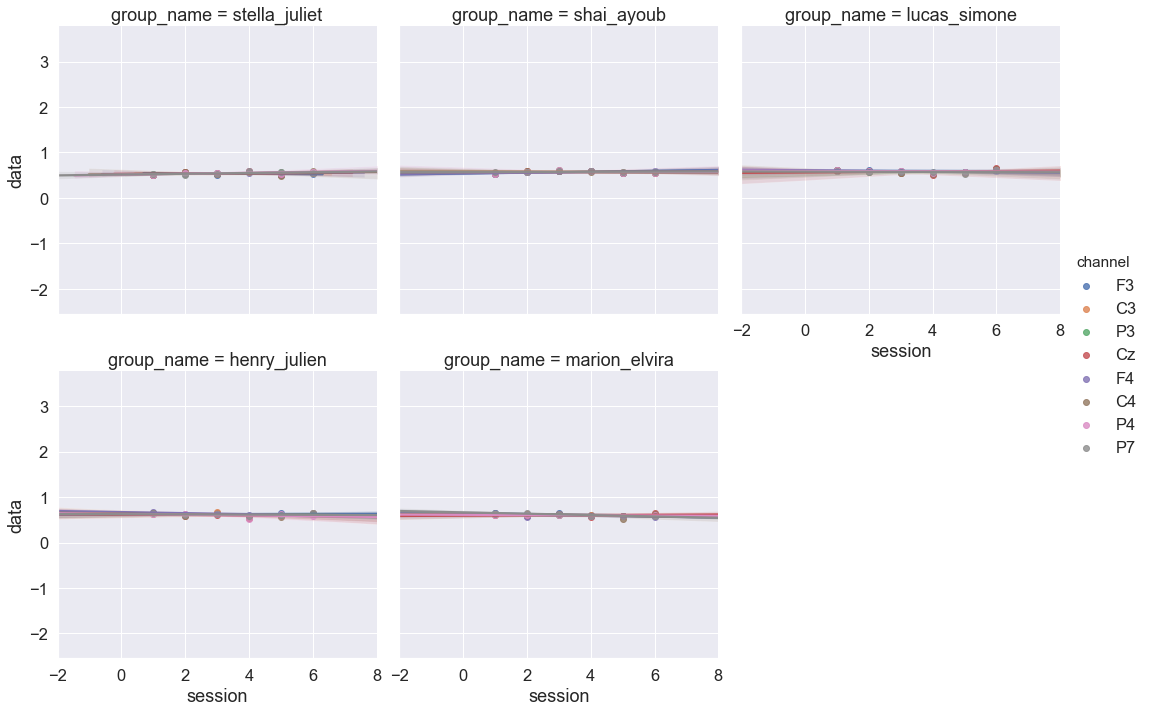

In [128]:
ax = sns.lmplot(x="session", y="data", col="group_name", hue="channel",col_wrap=3, data=a)
ax.set(xlim=(-2, 8))


# corss corelation between speaking and listing 
# eeg channels

In [4]:
freq = [1,4]


In [ ]:
# filter EEG data to bands



for s in range(0,len(subject_group)):
    save_path = data_path + '/python/data/'+'_'.join(subject_group[s])+'_EEG.pkl'
    A=pd.read_pickle(save_path)
    for i in range(0,A.shape[0]):
        tmp1 = []
        tmp2 = []
        for ch in range(0,len(eeg_label)):            
            x = butter_bandpass_filter(A['data_x'][i][ch,:], freq[0], freq[1], 500, order=4)
            tmp1.append(x)
            y = butter_bandpass_filter(A['data_y'][i][ch,:], freq[0], freq[1], 500, order=4)
            tmp2.append(y)
            
        tmp1 = np.asarray(tmp1)    
        tmp2 = np.asarray(tmp2)    

        A['data_x'][i] =  np.asarray(tmp1)    
        A['data_y'][i] =  np.asarray(tmp2)    
        
    save_path = data_path + '/python/data/'+'_'.join(subject_group[s])+'_EEG_filt_'+str(freq[0])+'-'+str(freq[1])+'.pkl'
    A.to_pickle(save_path)

In [8]:
# measure corealation between two subjects
R = []
for s in range(0,len(subject_group)):
    save_path = data_path + '/python/data/'+'_'.join(subject_group[s])+'_EEG_filt_'+str(freq[0])+'-'+str(freq[1])+'.pkl'
    A=pd.read_pickle(save_path)

    for i in range(0,A.shape[0]):
        tmp = []
        for ch in range(0,len(eeg_label)):
            if(A['data_x'][i][ch,:].shape[0]>A['data_y'][i][ch,:].shape[0]):
                aa = A['data_y'][i][ch,:].shape[0]
            else:
                aa = A['data_x'][i][ch,:].shape[0]

            r,p = stats.pearsonr(A['data_x'][i][ch,0:aa],A['data_y'][i][ch,0:aa])            
            tmp.append(r)
            
            
        tmp = np.asarray(tmp)    
        #df = pd.DataFrame({'group':'_'.join(subject_group[s]),'session':A['session'][i],'idx':A['idx'][i],
                           #eeg_label[0]:tmp[0],eeg_label[1]:tmp[1],eeg_label[2]:tmp[2],eeg_label[3]:tmp[3]
                          #,eeg_label[4]:tmp[4],eeg_label[5]:tmp[5],eeg_label[6]:tmp[6],eeg_label[7]:tmp[7]}, index=[0])
        df = pd.DataFrame({'group':'_'.join(subject_group[s]),'session':A['session'][i],'idx':A['idx'][i],
                           'data':[tmp]}, index=[0])
        R.append(df)   
        
R=pd.concat((R),axis=0)
R.head()  

save_path = data_path + '/python/data/'+'_EEG_filt_'+str(freq[0])+'-'+str(freq[1])+'_correaltion.pkl'
R.to_pickle(save_path)

In [48]:
#
save_path = data_path + '/python/data/_EEG_filt_1-4_correaltion.pkl'
R=pd.read_pickle(save_path)
tmp=[]
for s in range(0,5):
    for i in range(1,len(session_name)-1):
        a = R[(R['session']==session_name[i]) & (R['group']=='_'.join(subject_group[s]))]['data']
        a = np.stack(a, axis=0)
        a = np.nanmean(a,axis=0)
        df=pd.DataFrame({'group':'_'.join(subject_group[s]),'session':session_name[i],'Data':[a]})
        tmp.append(df)
    
df=pd.concat((tmp),axis=0)
 

#df.set_index(['session','group'], inplace=True)
#df.sort_index(inplace=True)    
df.head()     

,Data,group,session
0,"[0.007839593414955201, -0.012161059014842969, ...",stella_juliet,duet1
0,"[-0.012938112907980586, 0.006642518321821648, ...",stella_juliet,duet2
0,"[0.025776994043444846, 0.025616674856014942, 0...",stella_juliet,duet3
0,"[-0.013286091103243112, 0.010255200207605338, ...",stella_juliet,duet4
0,"[-0.033302737991720795, -0.016162449691140578,...",stella_juliet,duet5


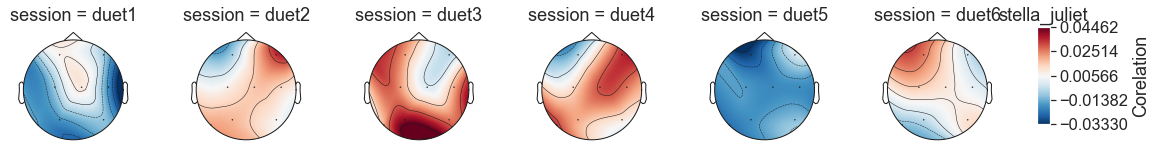

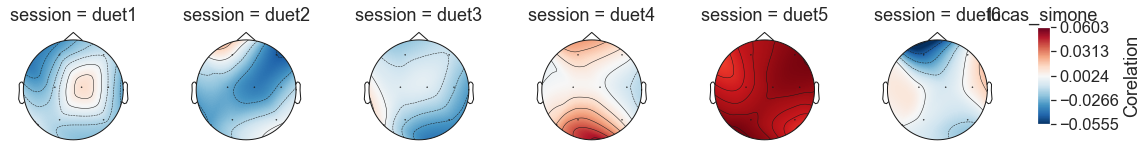

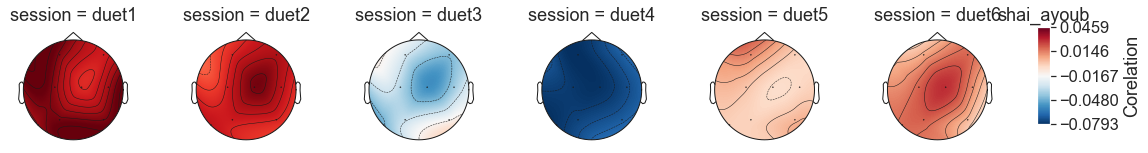

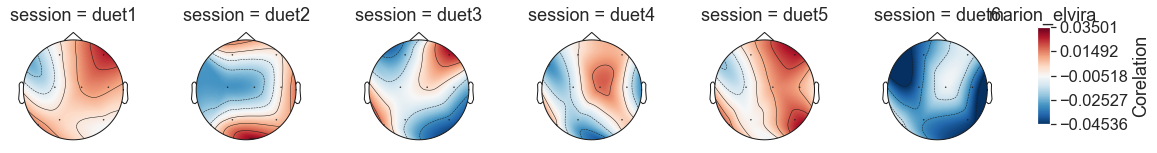

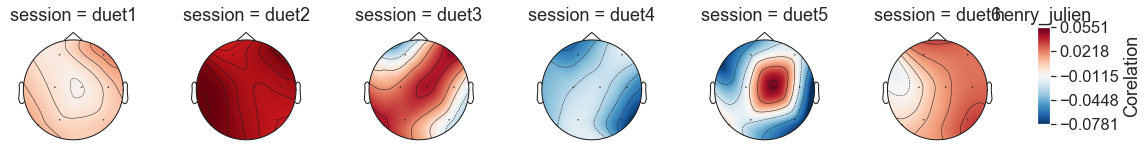

In [69]:
#
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mne.viz.plot_topomap(x, pos, show=False,vmin=vmin,vmax=vmax)

def plot_topo_image(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Corelation')
    
group = ['stella_juliet', 'lucas_simone', 'shai_ayoub', 'marion_elvira', 'henry_julien']
   
session = ['duet1', 'duet2', 'duet3' ,'duet4','duet5','duet6']

for g in group: 
    a = df[(df['group'] == g)]

    vmin = np.stack(a['Data'].get_values()).min()
    vmax = np.stack(a['Data'].get_values()).max()
    plot_topo_image(a,vmin,vmax,'session','RdBu_r')
    plt.title(g)